## 전처리

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("./data/train_V2.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [ ]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')>

In [ ]:
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [ ]:
df[df.winPlacePerc.isnull()==True]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [ ]:
df.drop(index=2744604, inplace=True)

## 가설

- 상관 없을 것으로 예상되는 지표 
    - Id
    - groupId
    - matchId
    - roadkills
- 높은 상관이 있을 것으로 예상하는 지표
    - assists
    - damageDealt
    - kills
    - walkDistance (-rideDist, swimDist)
    - killPlace
- 관련있을 것 같은 지표
    - boosts
    - heals
    - vehicleDestroys
    - weaponsAcquired
- 아직 정확히 파악하지 못한 지표
    - headshotKills
    - DBNOs
    - killPoints
    - killStreaks
    - matchType
    - maxPlace (≈numGroups)
- 활용하기 어려울 것으로 예상하는 지표
    - longestKill
    - matchDuration
    - rankPoints
    - revivies
    - teamkills
    - winPoints

## EDA

Text(0.5, 1.0, 'corr of features')

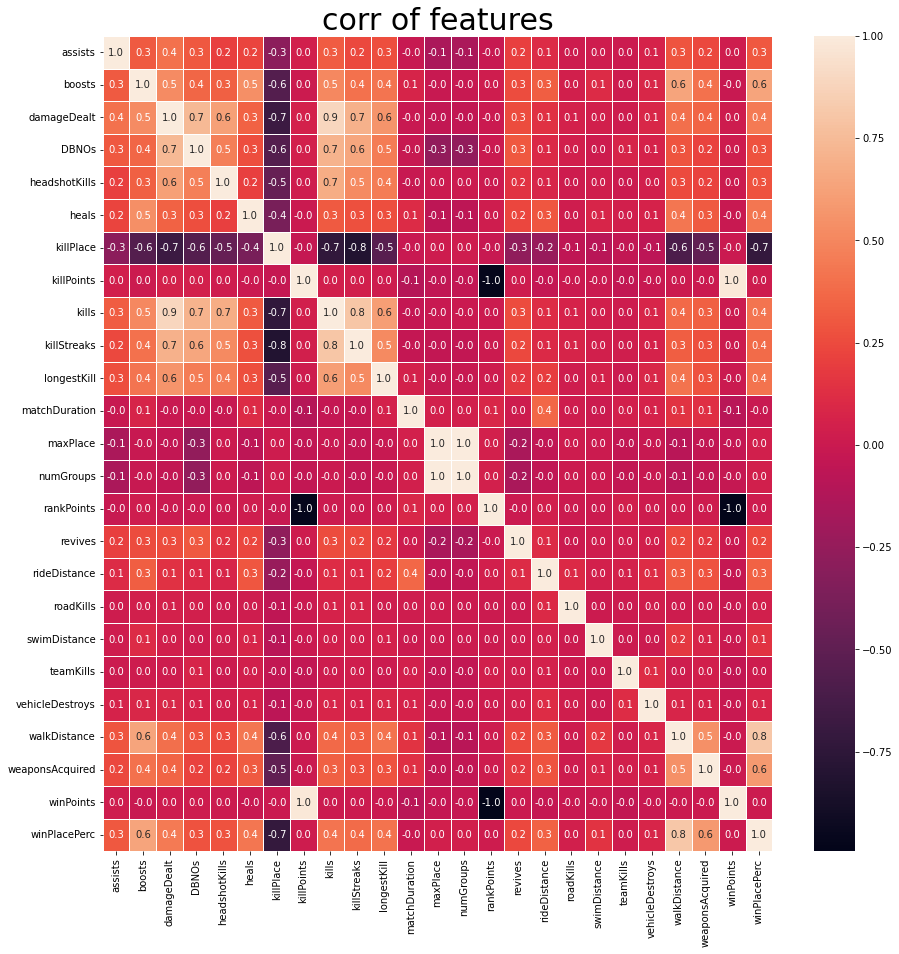

In [ ]:
plt.figure(figsize=(15,15)) #막 찍어본? 히트맵
sns.heatmap(data = df.corr(), annot=True, linewidths=0.5, fmt = "0.1f")
plt.title("corr of features", fontsize=30)

<h3>관련된 지표 : walkDistance(걸은 거리), weaponAcquired(주운 무기수), boosts(사용한 비-회복 아이템), killPlace(처치 순위)</h3>
우선적으로 초점을 맞출 지표 : 생존, 파밍, 능숙한 전투

*killPlace는 data leakage가 발견되어 제외하기로 결정*


- #### walkDistance : 생존 시간과 관련된 지표

<Figure size 1080x432 with 0 Axes>

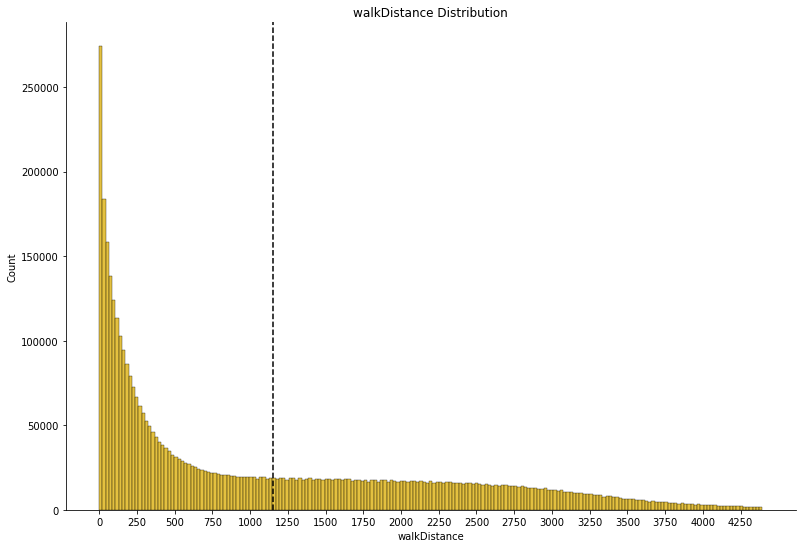

In [ ]:
#fig, axes = plt.subplots(2)
plt.figure(figsize=(15,6))
sns.displot(df[df.walkDistance<df.walkDistance.quantile(0.99)].walkDistance, height=7.5, aspect=1.5, color="#dbac00")
plt.axvline(df.walkDistance.mean(), color="black", linestyle="--")
plt.xticks(range(0,4500,250))
plt.title("walkDistance Distribution")
plt.show()

극단값 포함 평균이 1180 근처에서 형성되는 것을 볼 수 있으며, 대부분의 조기 탈락자가 먼 길을 가지 못했음을 확인 가능

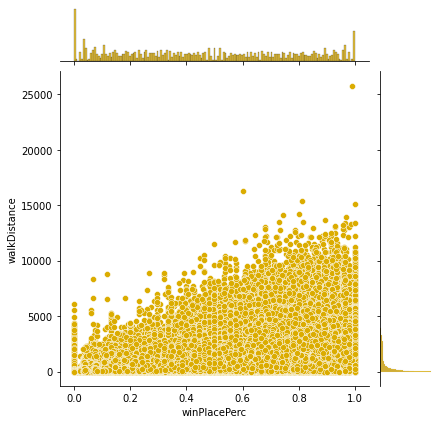

In [ ]:
sns.jointplot(x="winPlacePerc", y="walkDistance", data=df, color='#dbac00')


winPlacePerc와 뚜렷한 양의 상관관계를 보이는 것을 확인할 수 있음.

- #### Boosts : 파밍 및 능숙한 전투와 관련된 지표

<AxesSubplot:xlabel='boosts', ylabel='count'>

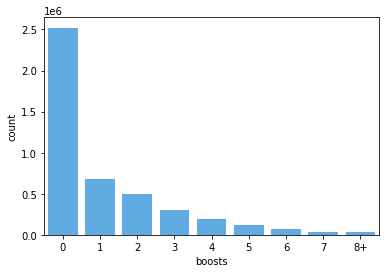

In [ ]:
tmpd = df.copy()
tmpd.loc[tmpd.boosts>tmpd.boosts.quantile(0.99)]="8+"
sns.countplot(x=tmpd.boosts.astype(str).sort_values(), data=tmpd, color='#4dadf7')

위와 마찬가지로 부스트 아이템의 사용율은 그리 높지 않음을 확인할 수 있다. 숙련도 문제이건, 파밍 문제이건 간에 아이템을 써보지도 못하고 죽는 유저가 많다.

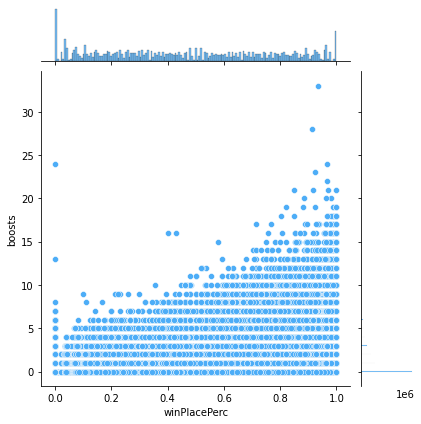

In [ ]:
sns.jointplot(x="winPlacePerc", y="boosts", data=df, color='#4dadf7')

즉 반대로 말하자면 부스트 아이템을 쓰는 유저는 최소한의 숙련/파밍이 이루어진 유저로 볼 수 있다.


winPlacePerc와 뚜렷한 양의 상관관계가 나타나는 것을 확인할 수 있다.

- #### weaponsAcquired : 파밍과 관련된 지표

In [ ]:
df.weaponsAcquired.quantile(0.5)

3.0

<AxesSubplot:xlabel='weaponsAcquired', ylabel='count'>

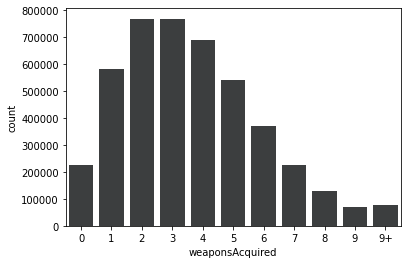

In [ ]:
tmpd = df.copy()
tmpd.loc[tmpd.weaponsAcquired>tmpd.weaponsAcquired.quantile(0.98)]="9+"
sns.countplot(x=tmpd.weaponsAcquired.astype(str).sort_values(), data=tmpd, color='#3b3e40')

평균적으로 3개씩의 무기를 주웠으며, 더 큰 수치로 갈 수록 비율이 줄어드는건 이전 지표와 같으나 적어도 무기를 하나는 먹은 사람이 많음을 확인할 수 있음.

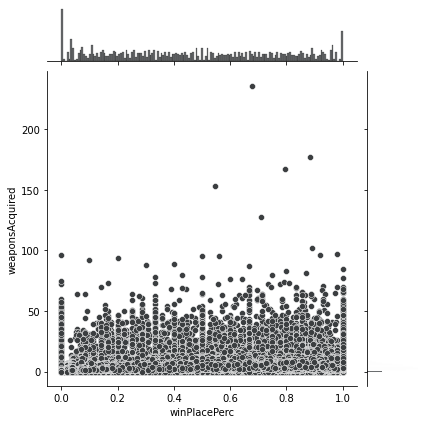

In [ ]:
sns.jointplot(x="winPlacePerc", y="weaponsAcquired", data=df, color="#3b3e40")

하지만 다른 지표들과는 다르게, jointPlot에서 뚜렷한 양의 상관관계가 나타나지는 않는 것으로 보인다. 어째서일까?

가설 1 : 0과 1+의 차이가 중요해서 그렇다. 


가설 2 : 50+ 이상의 outlier가 결과 도출을 방해해서 그렇다.

In [ ]:
df[["winPlacePerc","weaponsAcquired"]].corr() #원본

,winPlacePerc,weaponsAcquired
winPlacePerc,1.000000,0.583806
weaponsAcquired,0.583806,1.000000


In [ ]:
idkdata = df.loc[df.weaponsAcquired!=0]   #무기를 주운 사람만 계산시?  
idkdata[["weaponsAcquired","winPlacePerc"]].corr()
#단순히 무기를 집었다/아니다 이상의 의미가 큼

,weaponsAcquired,winPlacePerc
weaponsAcquired,1.000000,0.543004
winPlacePerc,0.543004,1.000000


In [ ]:
tmpd = df.copy()    #이상치 처리
tmpd.loc[tmpd.weaponsAcquired>tmpd.weaponsAcquired.quantile(0.98), "weaponsAcquired"]=9
tmpd[["winPlacePerc","weaponsAcquired"]].corr()

,winPlacePerc,weaponsAcquired
winPlacePerc,1.000000,0.631204
weaponsAcquired,0.631204,1.000000


결과: 무기를 주운 사람만 놓고 상관계수를 보아도 여전히 54%의 상관관계를 보이는 것으로 보아, 주운 무기 숫자가 오히려 무기 습득 여부보다 중요했음을 알 수 있다.


또한, 습득한 무기가 9개 이상인 사람들을 조정하고 상관관계 계산 시 수치가 63%로 오르는 것으로 보아, 이상치가 예측을 꽤 방해하고 있는 것으로 보인다.

- #### killPlace : 처치 순위, 전투와 관련된 지표

*하지만 matchid에 따라 winPlacePerc과 정렬되는 것으로 확인. 제외하고 분석할 지는 미정* 

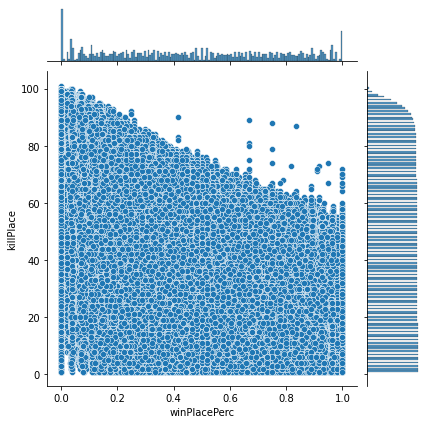

In [ ]:
sns.jointplot(x="winPlacePerc", y="killPlace", data=df)

순위에 따라 음의 상관관계를 보이는 것으로 확인되나, 킬 순위가 높다고 해서 무조건 승률로 이어지는 것은 아닌 것으로 보인다.



다만 킬 순위는 개인별로 집계되는 것으로 보아 그룹과 솔로 게임에서의 정확도가 다르게 나타날 수도 있다.

<AxesSubplot:xlabel='killPlace', ylabel='Count'>

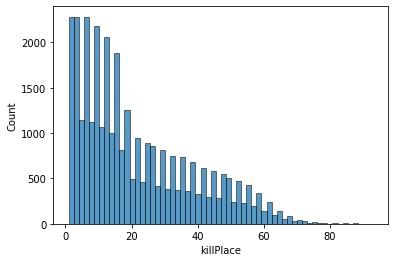

In [ ]:
sns.histplot(df[df.maxPlace<20].killPlace)

또한 자체 정원이 적은 사설방의 경우에도 킬 등수가 비정상적으로 분포하는 걸 확인할 수 있다. 방 인원수에 따라 등수를 정규화할 필요가 있을 수도 있다.

- #### 이상치 탐색 : 과도할 정도의 아이템을 습득한 경우, 이동 거리가 0인데 수많은 아이템을 획득한 경우 등

data를 직접 확인한 결과, 공통적으로 maxPlace 수치가 이상하다는 것을 발견함.

<AxesSubplot:title={'center':'maxPlace Distribution'}, xlabel='maxPlace', ylabel='count'>

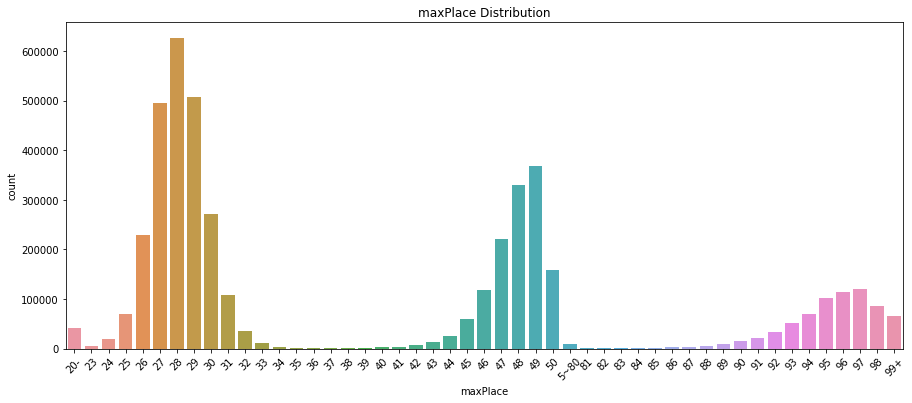

In [ ]:
data = df["maxPlace"].copy()    #순서상 뒤의 heal 이상치를 알아보기 위한 과정
data.loc[(data<80)&(data>50)] = 80
data.loc[data<data.quantile(0.01)] = "20-"
data.loc[data==80] = "5~80"
data.loc[data==100] = 99
data.loc[data==99] = "99+"
plt.figure(figsize=(15,6))
plt.title("maxPlace Distribution")
plt.xticks(rotation = 45)
sns.countplot(data = data, x = data.astype(str).sort_values())

보통의 데이터 분포에서, maxPlace는 솔로, 듀오, 스쿼드 모드에서 각각 90대-40대-25 근처에 분포해 있음을 알 수 있다.

<AxesSubplot:xlabel='maxPlace', ylabel='count'>

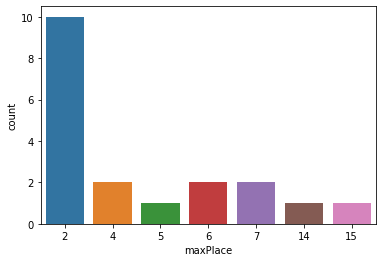

In [ ]:
sns.countplot(data = df, x = df[(df.winPlacePerc==0)&(df.heals>15)]['maxPlace'])  #힐 이상 = 사설 소규모 게임

하지만 이동 거리가 0이고, 치료 아이템을 15개 이상 먹은 플레이어들이 플레이한 매치는 방 정원수가 이상할 정도로 낮음을 알 수 있다.


따라서, 이들이 불법 프로그램을 사용하지 않았다면, 커스텀 설정으로 시작하자마자 힐, 무기, 혹은 트리거 데미지들을 적용시켰기 때문에 이런 이상치가 나타났다고 추측할 수 있다.

<AxesSubplot:xlabel='matchType', ylabel='count'>

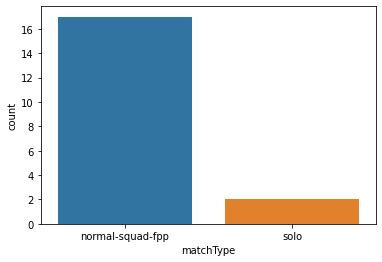

In [ ]:
sns.countplot(data = df, x = df[(df.winPlacePerc==0)&(df.kills>1)]['matchType']) #그리고 극소수

또한 이들의 matchType를 보았을 때, 이들이 주로 플레이한 방은 사설방(normal-)임을 알 수 있으며, 실제 매치에서 발견되는 이상치는 매우 적음을 알 수 있다.


이는 비인가 프로그램의 사용이라고도 볼 수 있지만, 우연히 기행을 한 플레이어나, 게임 db기록에 이상으로 인한 수치일 가능성도 배제할 수 없다.

<AxesSubplot:xlabel='maxPlace', ylabel='count'>

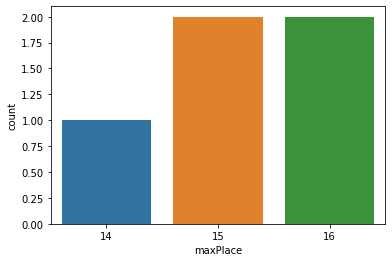

In [ ]:
sns.countplot(data = df, x = df[(df.winPlacePerc==0)&(df.heals>10)&(df.matchType=='solo')]['maxPlace']) #1대1은 아님 (그래프 생략가능)

더불어 이 기이한 플레이어들의 방 정원수도 상당히 낮은 것으로 보아, 정상적인 게임 자체가 이루어지지 않았음을 유추할 수 있다.